# Deep Learning
> A catalogue of not so deep ideas in Deep Learning.
- toc: true 
- badges: true
- comments: true
- categories: [Research]


Deep Learning is a collection of techniques for finding functions that can approximate arbitrary input-output mappings, while capturing enough structure of the problem to be able to use them in practical applicatons.language-translation systems,Image classification,Movie Recommendation systems are Some notable applications where they have become defacto-choice. This is by no means an exhaustive treatment of the field. Here I provide concise summaries,followed by a simple implementation of some of the most interesting ideas in the field. I believe that many things in the field are unnecessarily complicated by lengthy treatment where a readable code and short explanation will suffice. 

`Note` : This is not intended to be the first introduction to deep learning. Here I wanted to succintly catalogue some the latest advancements in the field. But, respecting tradition the first module starts from the basics. Only hard prerequisite is to have a good intuition of `matrix multiplication` notion of `taking a derivative`.

## Basics

Many deep learning models follow a simple recipe:

    1. Gather the data.
    2. Define learnable parameters. And specify how they will interact with the data.(architecture)
    3. Define a loss function to minimize.
    4. Adjust the parameters until satisfied.

### Train a linear regression model using gradient-descent.

Here we will see how we can perform all the above steps starting with the most barebones implementation. Note that the procedure outlined here is general purpose - meaning the way we adjust `parameters` is going to remain same irrecpective of the modality of the data, details of the loss function or the architecture.

Step 1. Gather the data

Let's generate some fake data.Let's assume that the data is coming from $y = 2*x1 - 4.2*x2 + 1 + noise(measurement error)$. This can be more succintly represented in vector notation :
$$y = \begin{bmatrix} x1 \\ x2 \end{bmatrix} . \begin{bmatrix} 2 \\ -4.2 \end{bmatrix} + 1$$


    


In [1]:
import numpy as np
def get_data(*params,const=None,rows=1000):
    #number of features in the input
    dim = len(params)
    x = np.random.normal(0,0.3,(rows,dim))
    y = x@np.array([params]).T
    if const:
        y += np.array([const])
    return x,y

x,y = get_data(2,-4.2,const=1)

x.shape,y.shape

((1000, 2), (1000, 1))

Step 2. Define learnable parameters. And specify how they will interact with the data.(architecture)

Now we aim to learn the right coefficients to approximate the data generation process. First let's look at some code.

In [2]:
# Start with a random guess that respects the sanctity of the data.i.e our inputs are of dimension 1000*2 
# outputs are 1000*1. Multiplying inputs by a 2*1 matrix(weights) and adding a constant(bias) is the simplest way
# to ensure an output of 1000*1. 

# initial guess
init_weights = np.array([[0.,-1.]]) #shape -> 1*2
init_bias = np.array([0.])

#expected output
def give_expected_output(inpt,weights,bias):
    return ((inpt@weights.T) + bias)

out = give_expected_output(x,init_weights,init_bias)#shape -> 1000*1

def get_error(out,expected_out):
    return np.mean((expected_out - out)**2)

get_error(out,y) # IF WE CAN DRIVE THIS NUMBER DOWN TO ZERO VIA A GENERAL PURPOSE PROCESS,WE ARE GOOD TO GO

2.121630476687219

In [3]:
def get_grads(weights,bias,x,y,loss_func='squared_loss'):
    if loss_func == 'squared_loss':
        weights_grad = 2*np.mean((x@weights.T + bias - y)*weights)
        bias_grad = 2*np.mean((x@weights.T + bias - y))
    else:
        print("Sorry I'm not yet scalable enough for arbitrary loss functions")
    return weights_grad,bias_grad
        


grad_init_weights,grad_bias = get_grads(init_weights,init_bias,x,y,loss_func = 'squared_loss')

def learn(x,y,init_weights,init_bias,loss_func,lr=0.001,epochs=5000):
    out = give_expected_output(x,init_weights,init_bias)
    error = loss_func(out,y)
    #print(f'initial error, epoch 0: {error}')
    errors = [error]
    pres_lr = lr
    for i in range(epochs):
        weight_grad,bias_grad = get_grads(init_weights,init_bias,x,y)
        init_weights -= weight_grad*pres_lr
        init_bias -= bias_grad*pres_lr
        out = give_expected_output(x,init_weights,init_bias)
        error = loss_func(out,y)
        if np.mean(weight_grad)<0.0001:
            pres_lr = pres_lr*2
        errors.append(error)
    return errors,init_weights,init_bias
        

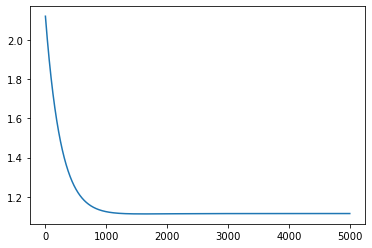

In [4]:
errors,final_weights,final_bias = learn(x,y,init_weights,init_bias,get_error)
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(errors)

In [5]:
final_weights,final_bias

(array([[-0.82604061, -1.82604061]]), array([0.97582166]))

## Deep RL Methods

### Motivation

Deep Learning allows for learning generalizable mappings between input and output. In supervised setting we are given a `fixed dataset` D = {$(x_{i},y_{i})$},and are tasked to predict $y_{i}$ using $x_{i}$. Thus, we know groud truth for all the input data. This let's us formulate a `loss` that reflects our dissatisfaction with the predicted `outputs` and optimize over it. But, consider how we learn to perform any new task ? The dataset and the learning signal comes sequentially and is also dependent on our actions. We don't have prepared datasets in real life. We learn from experience. `RL` deals with learning under this natural setting. The key difference to note is that the dataset is not `constant`, It changes everytime, contingent on your actions and the stochasticity in the environment. To make this clear, consider learning to play a video game. The pixels (call it `state`) and the score you receive ( call it `reward`) cannot be predetermined until you actually go through the experience. Here the dataset D = {$(state_{i},reward_{i})$} is not same everytime you play the game. `RL` provides a formalism for learning optimal decision making. This will become clear when we see some concrete examples and code. But combing these techniques with `Neural networks` has given us general algorithms that `learn to play atari games`, `beat world champions at Go` and `train robots to learn simple tasks`.
![](my_icons/rlsuc.png "Credit: http://rail.eecs.berkeley.edu/deeprlcourse/static/slides/lec-1.pdf")

### Problem

Consider the Following optimization problem. Find the shortest path from state $s_0$ to goal $g$,where the edges indicate the cost/distance ?

![](my_icons/sp.png "Credit: https://nanjiang.cs.illinois.edu/files/cs598/slides_intro_f20.pdf")